In [1]:
#
# In this quiz, you shall use the Stackoverflow dataset and perform a text classification task.
# Link:https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz
# Input: Question asked on StackOverflow
# Output: one of Python, CSharp, JavaScript, or Java
#
# Expected Takeaways: How do you load text data? How do you work with LSTMs?


### Data Loading, Standardization, Tokenization and Vectorization

In [9]:
# Import Libraries
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [3]:
# Data Loading
# https://www.tensorflow.org/tutorials/keras/text_classification

url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')


6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# loading train data
train_dir = './train'
train_dataset = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42)

validation_dataset = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42)

# loading test data
test_dir = './test'
test_dataset = tf.keras.utils.text_dataset_from_directory(test_dir, batch_size=32,seed=42)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.


In [5]:
# Explore the data
for text_batch, label_batch in train_dataset.take(1):
    print("Question", text_batch[0])
    print("Programming Language", label_batch[0])

Question tf.Tensor(b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the def

In [10]:
# Prepare the dataset for training
# Standardization (preproc-remove punc, html ele etc)
# Tokenization (Sentence -> Words/tokens) + Vectorization (Words/tokens -> Numbers)
max_features = 10000  # Maximum vocab size.
sequence_length = 250 #
vectorize_layer = layers.TextVectorization(
      max_tokens=max_features,
      output_mode='int',
      output_sequence_length=sequence_length

)

In [11]:
# Make a text-only dataset (without labels), then call adapt. Important to only use training data when using adapt
train_text = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [12]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [13]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", train_dataset.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
Label java
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3,  1

In [16]:
print("1011 --->", vectorize_layer.get_vocabulary()[1011])
print("2410 --->", vectorize_layer.get_vocabulary()[2410])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))


1011 ---> unit
2410 ---> getter
Vocabulary size: 10000


In [34]:
# As a final pre-proc step, apply the TextVectorization layer created to train,val and test dataset
train_ds = train_dataset.map(vectorize_text)
val_ds = validation_dataset.map(vectorize_text)
test_ds = test_dataset.map(vectorize_text)

In [30]:
# # I/O does not become blocking
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_dataset.map(lambda x, y: (tf.expand_dims(x, -1), y)).cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = validation_dataset.map(lambda x, y: (tf.expand_dims(x, -1), y)).cache().prefetch(buffer_size=AUTOTUNE)
# test_ds = test_dataset.map(lambda x, y: (tf.expand_dims(x, -1), y)).cache().prefetch(buffer_size=AUTOTUNE)

### Create the Model

In [31]:
embedding_dim =16

model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim), # Layer takes the integer encoded reviews an looks up an embedding vector for each word index
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(), # returns a fixed length output vector for each example by avg over the seq dimension
  layers.Dropout(0.2),
  layers.Dense(4, activation='sigmoid')])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Loss function and optimizer
model.compile(loss=losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.SparseCategoricalAccuracy()])

In [37]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.3811 - sparse_categorical_accuracy: 0.3071 - val_loss: 1.3541 - val_sparse_categorical_accuracy: 0.4650
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.3397 - sparse_categorical_accuracy: 0.4309 - val_loss: 1.2922 - val_sparse_categorical_accuracy: 0.4762
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.2747 - sparse_categorical_accuracy: 0.4899 - val_loss: 1.2122 - val_sparse_categorical_accuracy: 0.5375
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.1844 - sparse_categorical_accuracy: 0.5675 - val_loss: 1.1167 - val_sparse_categorical_accuracy: 0.6469
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0967 - sparse_categorical_accuracy: 0.6134 - val_loss: 1.0367 - val_sparse_categorical_accuracy: 0.6712
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.0170 - sparse_categorical_accuracy: 0.6488 - val_loss: 0.9632 - val_sparse_categorical_accuracy: 0.693

### Evaluate the Model

In [38]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8105 - sparse_categorical_accuracy: 0.7264
Loss:  0.8064948916435242
Accuracy:  0.7296249866485596


In [39]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

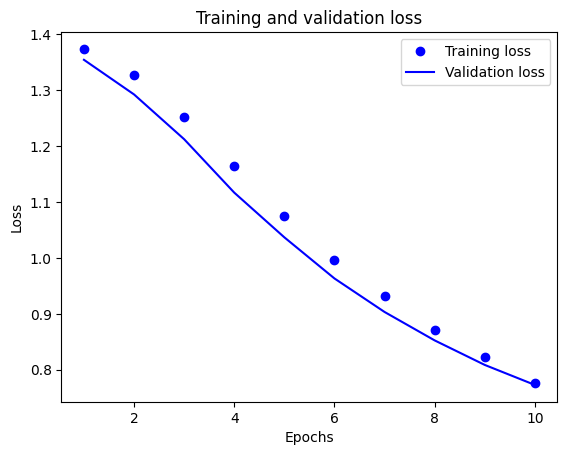

In [40]:
import matplotlib.pyplot as plt

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

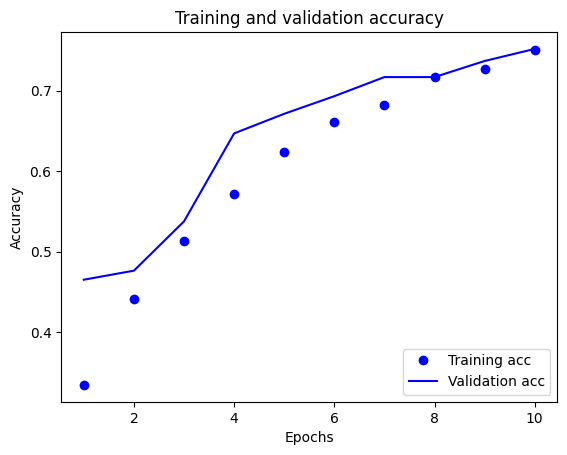

In [41]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Export the model

In [43]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(test_dataset, return_dict=True)
print(metrics)

250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7250 - loss: 0.0000e+00 - sparse_categorical_accuracy: 0.0000e+00
{'accuracy': 0.7296249866485596, 'loss': 0.0, 'sparse_categorical_accuracy': 0.0}


### Inference on the new data

In [52]:
import numpy as np
examples = tf.constant([
  "I just want to ask that how to take random string just like randint but this time with random string. Is there anyway?print('Hi. Please enter your name in letters')name= str(input())",
  "function getCSVString(){return ['nom', 'telèfon', 'email'].join(',') + '\n'+ filteredMembers.value.map(member => {return [member.nom, member.telèfon, member.email].join(',') + '\n'})}",
  "In order to see the actual size of each enum, let's make an actual enum and examine the contents of the class file it creates.Let's say we have the following Constants enum class:public enum Constants {ONE,TWO,THREE;}"
])

predictions = export_model.predict(examples)
print(predictions)
np.argmax(predictions, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
[[0.5685896  0.5087982  0.4961543  0.4264526 ]
 [0.4839007  0.3931374  0.6648914  0.47166   ]
 [0.5860039  0.54575324 0.45651245 0.4120066 ]]


array([0, 2, 0])

In [ ]:
# Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment,
# and reduces the potential for train/test skew.

#There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer.
#Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU.
#So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model,
#then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.